In [46]:
import gurobipy as gp
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from gurobipy import Model, GRB, quicksum
import pyepo

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#from sklearn_extra.cluster import KMedoids
import copy

In [47]:
# load data
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
# green = (0.31, 1, 0.34) # (79, 255, 87)
green = (0.122, 00.816, 0.51) # (31, 208, 130)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 53.32 # 90% quantile

def import_data(negative_prices=False):
    # import data and set constants
    all_data = pd.read_csv("2020_data.csv")
    prices_UP = np.maximum(all_data["UP"].to_numpy(),0)
    prices_DW = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    nominal_wind = 10
    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    price_H = 35.2
    penalty = np.quantile(prices_UP, 0.95) # 95% quantile of deficit_settle price over all 2 years
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_UP,
        prices_DW,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        penalty
    )

In [48]:
import os
# get current directory
path = os.getcwd()
import os.path

def getParent(path, levels = 1):
    common = path
 
    # Using for loop for getting
    # starting point required for
    # os.path.relpath()
    for i in range(levels + 1):
 
        # Starting point
        common = os.path.dirname(common)
 
    # Parent directory upto specified
    # level
    return os.path.relpath(path, common)


In [49]:
#Import data
(prices_UP,prices_DW,prices_F,prices_forecast,features,features_red,realized,price_H,penalty) = import_data()

# Change forward prices to forecast prices in features
features["forward"] = prices_forecast

periods = list(range(0, len(prices_F) )) # Total time considered 2020-2021
n_periods = 24 # Number of periods in a day
n_days = 50 # Number of days in training set and test set
n_hours = n_days * n_periods
num_feat = n_periods*6 # size of feature
num_item = 4*24 # number of predictions (Forward bid and Hydrogen)

lambda_H_list = [price_H for i in range(n_periods)]

def flatten_extend(matrix):
     flat_list = []
     for row in matrix:
         flat_list.extend(row)
     return flat_list

In [87]:
from pyepo.model.grb import optGrbModel

# optimization model
class hydrogenPlanning(optGrbModel):
    def __init__(self, realized, *args, **kwargs):        
        #Fixed parameters
        self.max_elec = 10
        self.max_wind = 10
        self.nominal_wind = 10
        self.min_production = 50
        self.periods = np.arange(len(realized))
        self.E_real = realized
        super().__init__()

    def _getModel(self):

        self.initial_plan = Model("Gurobi.Optimizer")

        # Definition of variables
        self.var = self.initial_plan.addVars((4*len(self.periods)), name="x")

        # Objective: Maximize profit
        self.initial_plan.modelSense = GRB.MAXIMIZE

        # Constraints
        # Max capacity
        self.initial_plan.addConstr(self.min_production <= gp.quicksum(self.var[t] for t in self.periods), name="min_hydrogen_production")
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"elec_capacity_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_elec, name=f"elec_capacity_ub_{t}")
        for t in np.arange(len(self.periods),2*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= -self.max_elec, name=f"wind_capacity_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= self.max_wind, name=f"wind_capacity_ub_{t}")
        for t in np.arange(2*len(self.periods),3*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"up_regulation_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= 10*self.max_wind, name=f"up_regulation_ub_{t}")
        for t in np.arange(3*len(self.periods),4*len(self.periods)):
            self.initial_plan.addConstr(self.var[t] >= 0, name=f"dw_regulation_lb_{t}")
            self.initial_plan.addConstr(self.var[t] <= 10*self.max_wind, name=f"dw_regulation_ub_{t}")
        for t in np.arange(0,len(self.periods)):
            self.initial_plan.addConstr(self.E_real[t] - self.var[t] - self.var[t+24] == -self.var[t+48] + self.var[t+72], name=f"balancing_{t}")
            #initial_plan.addConstr(-x[0,t] + self.min_production/len(self.periods) - x[4,t] <= 0, name=f"slack_{t}")
        self.initial_plan.addConstr(gp.quicksum(self.var[t] for t in np.arange(0,len(self.periods))) == self.min_production, name="min_hydrogen_production")
        
        return self.initial_plan, self.var
    
    def setObjective(self, c):
        # Objective: Maximize profit
        self.initial_plan.setObjective(gp.quicksum(self.var[t]*c[t] for t in np.arange(0,4*len(self.periods))), GRB.MAXIMIZE)

    def get_plan(self):
        self.initial_plan.optimize()
        self.initial_plan.update()
        x_values = []
        for var in model.initial_plan.getVars():
            x_values.append(var.x)
        hydrogen = x_values[0:len(self.periods)]
        forward_bids = x_values[len(self.periods):2*len(self.periods)]
        return forward_bids, hydrogen

In [58]:
# 
c_train = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods]]) for d in range(int(n_hours/n_periods))])
c_test = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods]]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])
wind_train = np.asarray([flatten_extend([realized[d:d+n_periods]]) for d in range(int(n_hours/n_periods))])
wind_test = np.asarray([flatten_extend([realized[d:d+n_periods]]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])
x_train = np.asarray([flatten_extend(features.values[d:d+n_periods]) for d in range(int(n_hours/n_periods))])
x_test = np.asarray([flatten_extend(features.values[d:d+n_periods]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])

# Standardize x_train and x_test
mu_train = np.mean(x_train, axis=0)
std_train = np.std(x_train, axis=0)
x_train = (x_train - mu_train) / std_train
x_test = (x_test - mu_train) / std_train

In [59]:
# get optDataset
from pyepo.data.datasetParams import optDatasetParams

dataset_train = optDatasetParams(hydrogenPlanning, x_train, c_train, wind_train)
dataset_test = optDatasetParams(hydrogenPlanning, x_test, c_test, wind_test)

batch_size = 1
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 122.92it/s]


Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 114.17it/s]


In [60]:
# prediction model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        #self.linear = nn.Linear(num_feat, num_item)
        self.linear = nn.Sequential( 
            nn.Linear(input_size, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        out = self.linear(x)
        return out

In [61]:
import time
from tqdm import tqdm
from pyepo.metric.regretParams import regretParams


# train model
def trainModel(reg, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
    criterion = torch.nn.MSELoss()
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [regretParams(reg, hydrogenPlanning, loader_test, wind_test)]
    # init elapsed time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        l = []
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            
            loss = criterion(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            l.append(np.sqrt(loss.item()))
        loss_log.append(np.mean(l))
        regret = regretParams(reg, hydrogenPlanning, loader_test, wind_test)
        loss_log_regret.append(regret)
        lr_scheduler.step()
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [62]:
reg = LinearRegression(num_feat, num_item)

# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

loss_log, loss_log_regret = trainModel(reg, num_epochs=50)

100%|██████████| 50/50 [00:00<00:00, 97.01it/s]


Epoch  1,  Loss:  194.4293,  Regret: 18.3684%


100%|██████████| 50/50 [00:00<00:00, 93.67it/s]


Epoch  2,  Loss:  475.5312,  Regret: 59.0686%


100%|██████████| 50/50 [00:00<00:00, 92.61it/s] 


Epoch  3,  Loss:  138.9026,  Regret: 23.0182%


100%|██████████| 50/50 [00:00<00:00, 89.11it/s]


Epoch  4,  Loss: 2037.7753,  Regret: 42.0913%


100%|██████████| 50/50 [00:00<00:00, 87.02it/s]


Epoch  5,  Loss:  369.5555,  Regret: 37.8142%


100%|██████████| 50/50 [00:00<00:00, 87.93it/s]


Epoch  6,  Loss:  196.4700,  Regret: 31.2595%


100%|██████████| 50/50 [00:00<00:00, 98.60it/s] 


Epoch  7,  Loss:  460.7191,  Regret: 35.4779%


100%|██████████| 50/50 [00:00<00:00, 100.14it/s]


Epoch  8,  Loss:  617.2183,  Regret: 23.3989%


100%|██████████| 50/50 [00:00<00:00, 99.99it/s] 


Epoch  9,  Loss:  790.9749,  Regret: 29.1587%


100%|██████████| 50/50 [00:00<00:00, 100.06it/s]


Epoch 10,  Loss:  151.1335,  Regret: 23.3143%


100%|██████████| 50/50 [00:00<00:00, 102.75it/s]


Epoch 11,  Loss:   81.1571,  Regret: 18.2129%


100%|██████████| 50/50 [00:00<00:00, 98.46it/s] 


Epoch 12,  Loss:  544.0096,  Regret: 16.1480%


100%|██████████| 50/50 [00:00<00:00, 105.26it/s]


Epoch 13,  Loss:   69.0166,  Regret: 22.1011%


100%|██████████| 50/50 [00:00<00:00, 98.22it/s]


Epoch 14,  Loss:   93.4421,  Regret: 23.9994%


100%|██████████| 50/50 [00:00<00:00, 99.97it/s] 


Epoch 15,  Loss: 1048.8148,  Regret: 35.5104%


100%|██████████| 50/50 [00:00<00:00, 105.08it/s]


Epoch 16,  Loss:  600.1913,  Regret: 14.2341%


100%|██████████| 50/50 [00:00<00:00, 100.25it/s]


Epoch 17,  Loss:  130.9177,  Regret: 29.6162%


100%|██████████| 50/50 [00:00<00:00, 106.05it/s]


Epoch 18,  Loss:   88.5967,  Regret: 14.2710%


100%|██████████| 50/50 [00:00<00:00, 103.36it/s]


Epoch 19,  Loss:  725.7955,  Regret: 17.3825%


100%|██████████| 50/50 [00:00<00:00, 100.06it/s]


Epoch 20,  Loss:  504.3191,  Regret: 16.2830%


100%|██████████| 50/50 [00:00<00:00, 104.67it/s]


Epoch 21,  Loss:   87.0923,  Regret: 13.1181%


100%|██████████| 50/50 [00:00<00:00, 103.54it/s]


Epoch 22,  Loss:   98.7817,  Regret: 15.9529%


100%|██████████| 50/50 [00:00<00:00, 101.88it/s]


Epoch 23,  Loss:  394.4306,  Regret: 12.1836%


100%|██████████| 50/50 [00:00<00:00, 101.95it/s]


Epoch 24,  Loss:  218.5704,  Regret: 12.0269%


100%|██████████| 50/50 [00:00<00:00, 100.07it/s]


Epoch 25,  Loss:  251.6543,  Regret: 16.2108%


100%|██████████| 50/50 [00:00<00:00, 106.97it/s]


Epoch 26,  Loss:   32.0685,  Regret: 12.7922%


100%|██████████| 50/50 [00:00<00:00, 100.10it/s]


Epoch 27,  Loss:   46.6623,  Regret: 12.2989%


100%|██████████| 50/50 [00:00<00:00, 102.21it/s]


Epoch 28,  Loss:  102.9670,  Regret: 15.8903%


100%|██████████| 50/50 [00:00<00:00, 104.56it/s]


Epoch 29,  Loss:  314.2597,  Regret: 11.9105%


100%|██████████| 50/50 [00:00<00:00, 96.27it/s] 


Epoch 30,  Loss:   62.6387,  Regret: 12.8448%


100%|██████████| 50/50 [00:00<00:00, 97.12it/s]


Epoch 31,  Loss:  222.5128,  Regret: 12.9603%


100%|██████████| 50/50 [00:00<00:00, 97.44it/s]


Epoch 32,  Loss:   37.5631,  Regret: 12.3150%


100%|██████████| 50/50 [00:00<00:00, 98.01it/s] 


Epoch 33,  Loss:  131.8252,  Regret: 15.4391%


100%|██████████| 50/50 [00:00<00:00, 82.57it/s]


Epoch 34,  Loss:   94.6153,  Regret: 13.4859%


100%|██████████| 50/50 [00:00<00:00, 89.82it/s]


Epoch 35,  Loss:  212.0566,  Regret: 13.2580%


100%|██████████| 50/50 [00:00<00:00, 94.76it/s]


Epoch 36,  Loss:   66.5303,  Regret: 15.6288%


100%|██████████| 50/50 [00:00<00:00, 96.06it/s] 


Epoch 37,  Loss:  115.4841,  Regret: 12.3173%


100%|██████████| 50/50 [00:00<00:00, 98.30it/s] 


Epoch 38,  Loss:  165.6122,  Regret: 12.0705%


100%|██████████| 50/50 [00:00<00:00, 87.63it/s]


Epoch 39,  Loss:   49.8329,  Regret: 12.5425%


100%|██████████| 50/50 [00:00<00:00, 85.79it/s]


Epoch 40,  Loss:   64.6802,  Regret: 11.9073%


100%|██████████| 50/50 [00:00<00:00, 97.84it/s]


Epoch 41,  Loss:   28.8110,  Regret: 12.0278%


100%|██████████| 50/50 [00:00<00:00, 101.42it/s]


Epoch 42,  Loss:   21.8376,  Regret: 11.8325%


100%|██████████| 50/50 [00:00<00:00, 105.04it/s]


Epoch 43,  Loss:   69.2144,  Regret: 11.7093%


100%|██████████| 50/50 [00:00<00:00, 90.46it/s] 


Epoch 44,  Loss:  301.5815,  Regret: 12.0244%


100%|██████████| 50/50 [00:00<00:00, 93.51it/s]


Epoch 45,  Loss:  219.4639,  Regret: 11.9596%


100%|██████████| 50/50 [00:00<00:00, 103.57it/s]


Epoch 46,  Loss:   85.3467,  Regret: 11.8316%


100%|██████████| 50/50 [00:00<00:00, 100.07it/s]


Epoch 47,  Loss:  117.6375,  Regret: 12.0203%


100%|██████████| 50/50 [00:00<00:00, 100.06it/s]


Epoch 48,  Loss:   99.2627,  Regret: 12.2329%


100%|██████████| 50/50 [00:00<00:00, 101.82it/s]


Epoch 49,  Loss:   63.1136,  Regret: 11.8709%


100%|██████████| 50/50 [00:00<00:00, 103.54it/s]

Epoch 50,  Loss:  177.8752,  Regret: 12.6869%
Total Elapsed Time: 159.20 Sec.


In [63]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Epochs", fontsize=16)
    ax1.set_ylabel("RMSE", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

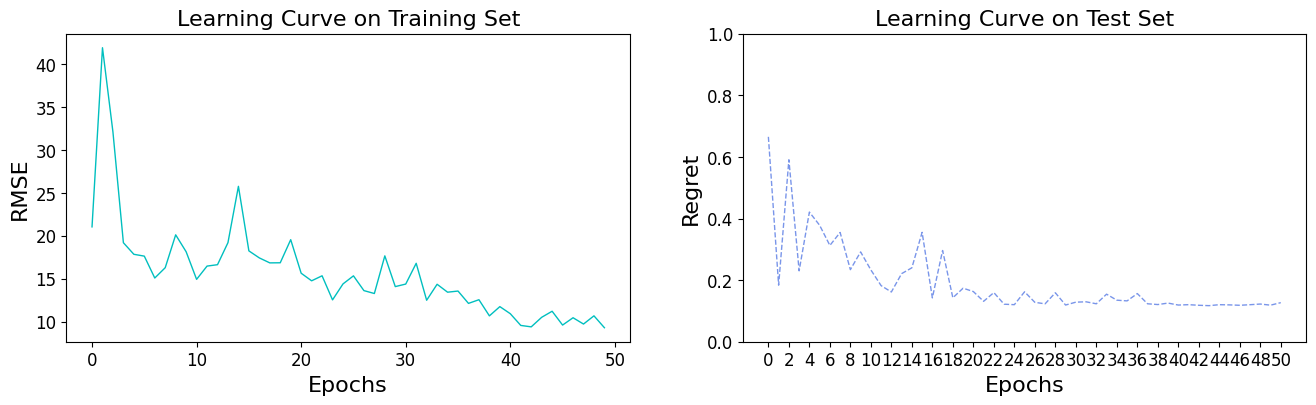

In [64]:
visLearningCurve(loss_log, loss_log_regret)

In [92]:
forward_bids = []
hydrogen_plan = []
reg.eval()
for i, data in enumerate(loader_test):
    x, c, w, z = data
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    predicted_costs = reg(x).detach().numpy()[0]
    model = hydrogenPlanning(realized=wind_test[i])
    model.setObjective(predicted_costs)
    forward, hydrogen = model.get_plan()
    forward_bids.extend(forward)
    hydrogen_plan.extend(hydrogen)

In [116]:
pd.DataFrame({"forward bid" : forward_bids,"hydrogen production" : hydrogen_plan}).to_csv("SLO_base.csv")
